<a href="https://colab.research.google.com/github/pboric/Project-10/blob/main/spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the year 2912, the interstellar passenger liner Spaceship Titanic encountered a spacetime anomaly concealed within a dust cloud. Tragically, it suffered a fate reminiscent of its namesake from a millennium ago. Although the ship remained intact, nearly half of the passengers were transported to an alternate dimension! To aid rescue teams in retrieving the lost passengers, we must utilize records salvaged from the spaceship’s damaged computer system to predict which passengers were transported to another dimension.


*This problem involves binary classification, where we need to predict whether passengers were transported to an alternate dimension or not.*


# About the data

We will be using three CSV files:

- **Train file (train.csv)**: Contains personal records of the passengers, which will be used to build the machine learning model.
- **Test file (test.csv)**: Contains personal records for the remaining one-third (~4300) of the passengers, but does not include the target variable (i.e., the value of Transported for the passengers). This file will be used to evaluate how well our model performs on unseen data.
- **Sample submission file (sample_submission.csv)**: Provides the format in which we need to submit our predictions.

# Libraries

In [ ]:
import utils
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# For inferential stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
import scipy.stats as stats

# For Correlations
from sklearn.preprocessing import LabelEncoder

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# For building and evaluating models
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import optuna
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

# Data loading

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

# EDA

## Descriptive stats

In [ ]:
train_df_1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [ ]:
test_df_1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

Description for each variable:

- **PassengerId** — A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** — The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** — Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** — The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** — The planet the passenger will be debarking to.
- **Age** — The age of the passenger.
- **VIP** — Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** — Amount the passenger has billed at each of the Spaceship Titanic’s many luxury amenities.
- **Name** — The first and last names of the passenger.
- **Transported** — Whether the passenger was transported to another dimension. This is the target, the column we are trying to predict.

In [ ]:
train_df_1.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

- **object** (Categorical variables) — The categorical variables in the training dataset are: `PassengerId`, `HomePlanet`, `CryoSleep`, `Cabin`, `Destination`, `VIP` and `Name`
- **float64** (Float variables i.e Numerical variables which have some decimal values involved) — The Numerical variables in our train dataset: `Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` and `VRDeck`
- **bool** (Boolean variables i.e. a variable that has one of two possible values e.g. True or False) — The Boolean Variable in our dataset is `Transported`

In [ ]:
print(f"Train shape: {train_df_1.shape}, Test shape: {test_df_1.shape}")

Train shape: (8693, 14), Test shape: (4277, 13)


## Univariate analysis

### Target variable (Transported)

Since it is a categorical variable, let us look at its percentage distribution and bar plot.


- *Normalize is set to true to print proportions instead of number*
- *Calculate the number of passengers transported and not transported*


Transported Counts:
True     4378
False    4315
Name: Transported, dtype: int64

Transported Percentages:
True    50.36
False   49.64
Name: Transported, dtype: float64


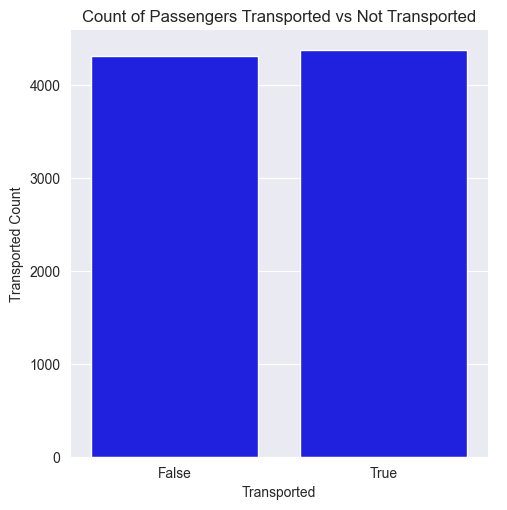

In [ ]:
transported_counts = train_df_1['Transported'].value_counts()
transported_percentages = train_df_1['Transported'].value_counts(normalize=True) * 100

print("Transported Counts:")
print(transported_counts)
print("\nTransported Percentages:")
print(transported_percentages)

ax = sns.catplot(x="Transported", data=train_df_1, kind="count", color="b")
ax.set_axis_labels("Transported", "Transported Count")
plt.title('Count of Passengers Transported vs Not Transported')
plt.show()

Out of 8693 passengers in the train dataset, 4378 (about 50%) were Transported to another dimension.

### Independent variables (Categorical)

<Axes: title={'center': 'VIP'}>

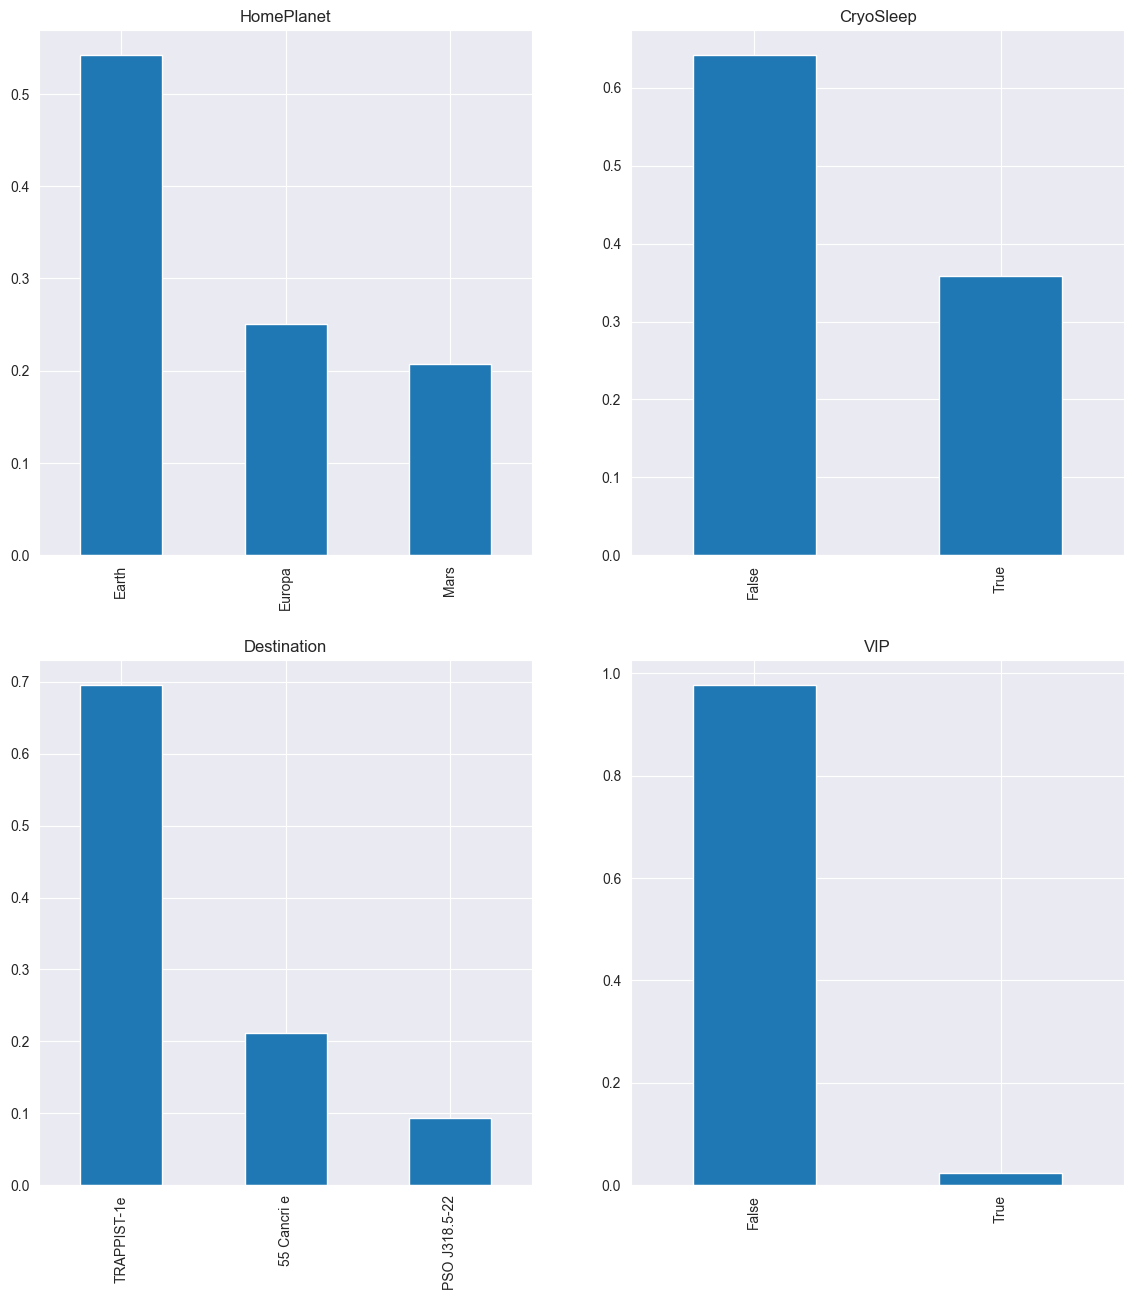

In [ ]:
plt.figure(figsize = (14, 15))
plt.subplot(221)
train_df_1['HomePlanet'].value_counts(normalize = True).plot.bar(title = 'HomePlanet')
plt.subplot(222)
train_df_1['CryoSleep'].value_counts(normalize = True).plot.bar(title = 'CryoSleep')
plt.subplot(223)
train_df_1['Destination'].value_counts(normalize = True).plot.bar(title = 'Destination')
plt.subplot(224)
train_df_1['VIP'].value_counts(normalize = True).plot.bar(title = 'VIP')

- About 50% of passengers in the trainset departed from Earth
- About 30% of the passengers in the training dataset were on CryoSleep (i.e confined to their cabins.)
- About 69% of the passengers in the training dataset were going to TRAPPIST-1e
- Not up to 1% of the passengers on the training dataset paid for VIP services

The cabin column takes the form deck/num/side. Let’s extract and visualize the `CabinDeck` and `CabinSide` features.

- *Extract CabinDeck, CabinNo. and CabinSide feature from Cabin*

<Axes: title={'center': 'CabinSide'}>

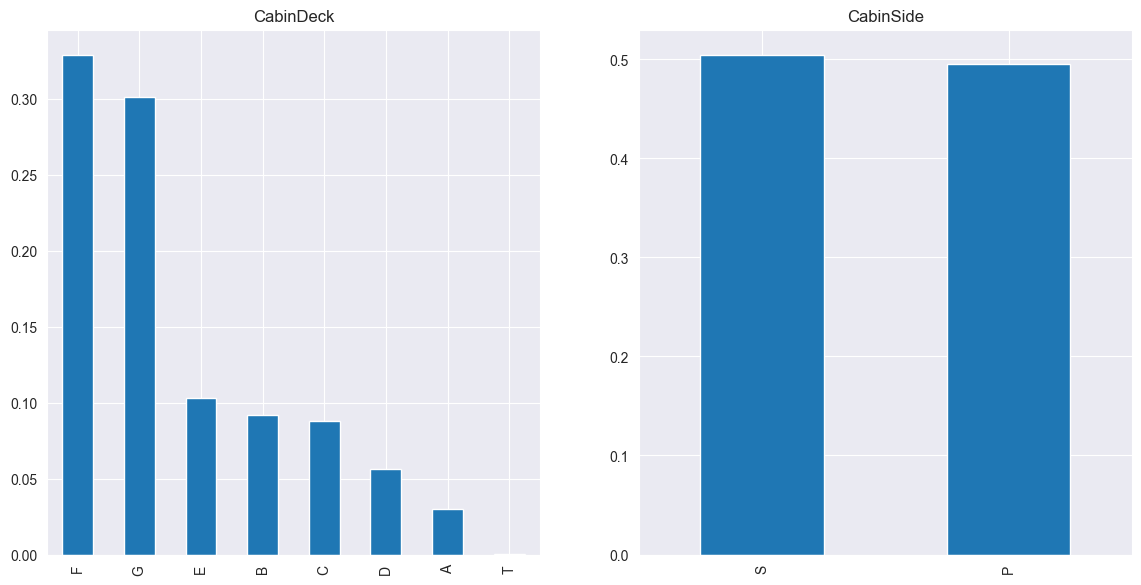

In [ ]:
train_df_1[["CabinDeck", "CabinNo.", "CabinSide"]] = train_df_1["Cabin"].str.split('/', expand = True)

plt.figure(figsize = (14, 15))
plt.subplot(221)
train_df_1['CabinDeck'].value_counts(normalize = True).plot.bar(title = 'CabinDeck')
plt.subplot(222)
train_df_1['CabinSide'].value_counts(normalize = True).plot.bar(title = 'CabinSide')

- About 60% of the passengers in the train set were on deck F and G
- There’s not much difference between the % of passengers that were on Cabin side S compared to P

### Independent variables (Numerical)

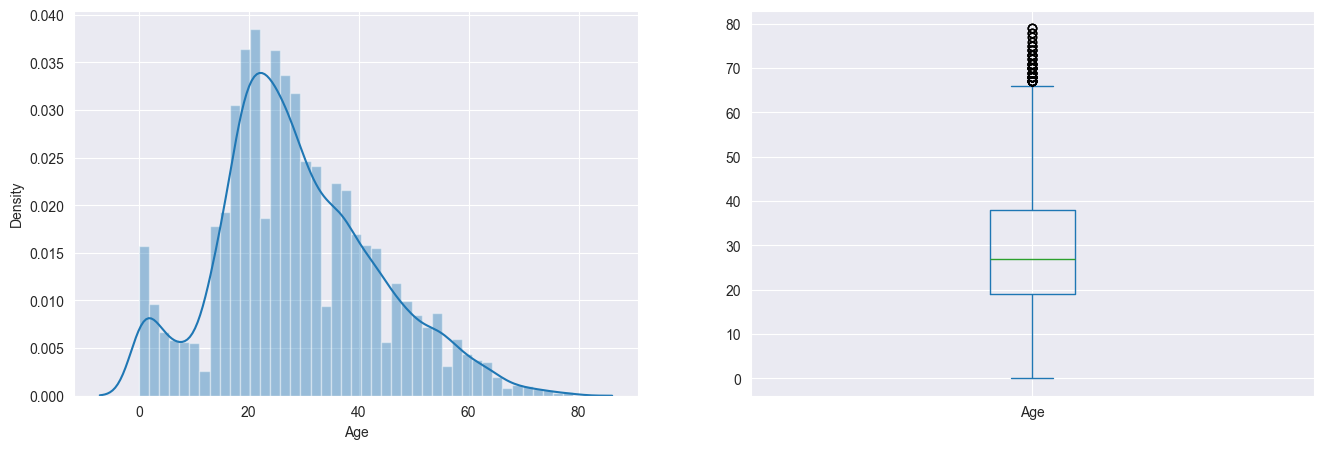

In [ ]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['Age']);
plt.subplot(122)
train_df_1['Age'].plot.box(figsize = (16, 5));
plt.show()

There are outliers in the `Age` variable and the distribution is fairly normal.

In [ ]:
shapiro_test = stats.shapiro(train_df_1['Age'].dropna())
print(f"Shapiro-Wilk Test Statistic: {shapiro_test.statistic}")
print(f"Shapiro-Wilk Test p-value: {shapiro_test.pvalue}")
if shapiro_test.pvalue < alpha:
    print("We reject the null hypothesis. The Age variable is not normally distributed.")
else:
    print("We fail to reject the null hypothesis. The Age variable is normally distributed.")

Shapiro-Wilk Test Statistic: 0.980870585934988
Shapiro-Wilk Test p-value: 2.698924692428031e-32
We reject the null hypothesis. The Age variable is not normally distributed.


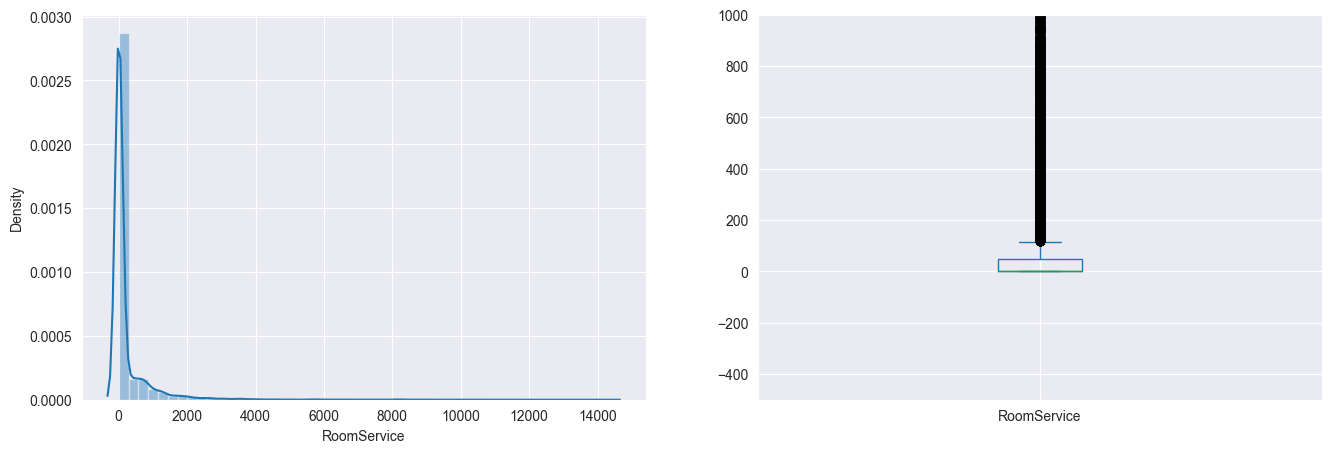

In [ ]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['RoomService']);
plt.subplot(122)
train_df_1['RoomService'].plot.box(figsize = (16, 5));
plt.ylim([-500, 1000])
plt.show()

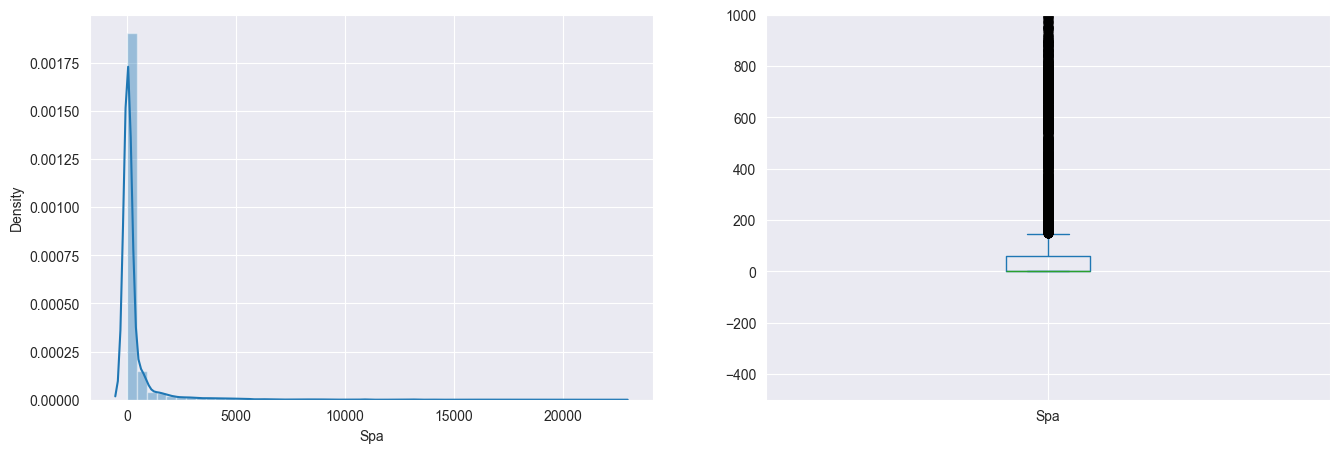

In [ ]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['Spa']);
plt.subplot(122)
train_df_1['Spa'].plot.box(figsize = (16, 5));
plt.ylim([-500, 1000])
plt.show()

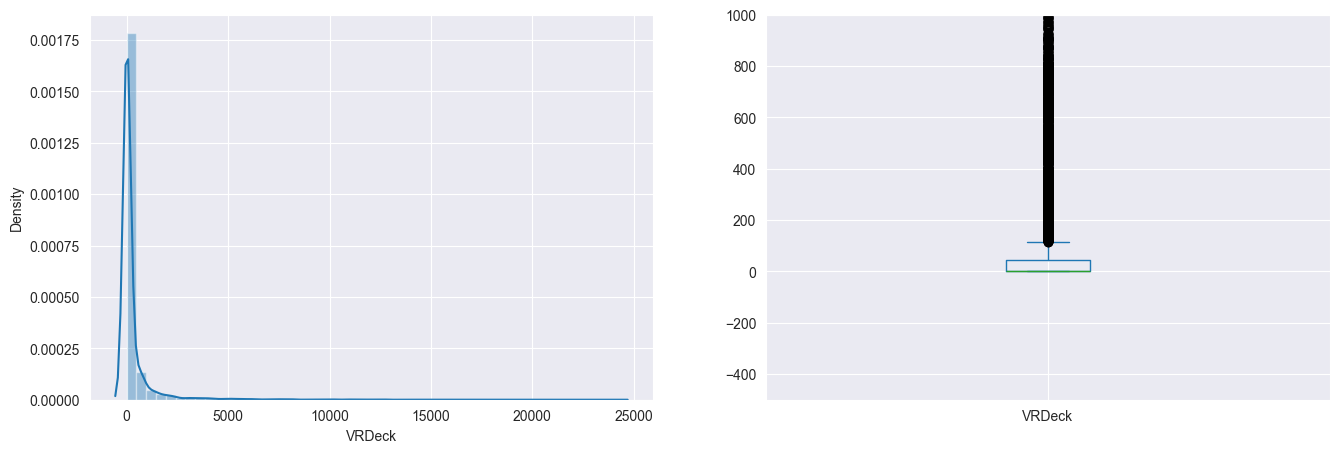

In [ ]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['VRDeck']);
plt.subplot(122)
train_df_1['VRDeck'].plot.box(figsize = (16, 5));
plt.ylim([-500, 1000])
plt.show()

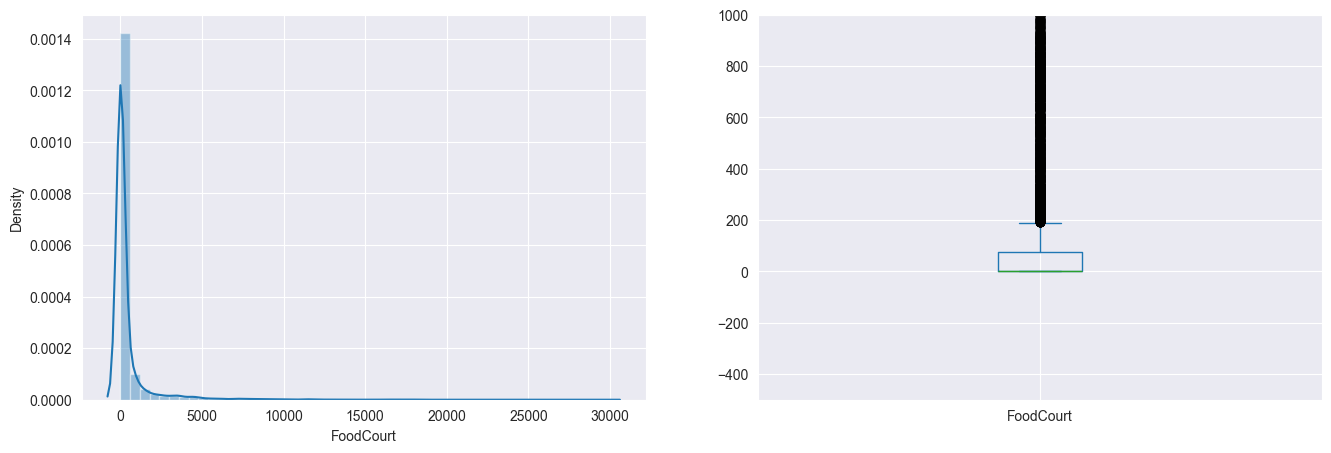

In [ ]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['FoodCourt']);
plt.subplot(122)
train_df_1['FoodCourt'].plot.box(figsize = (16, 5));
plt.ylim([-500, 1000])
plt.show()

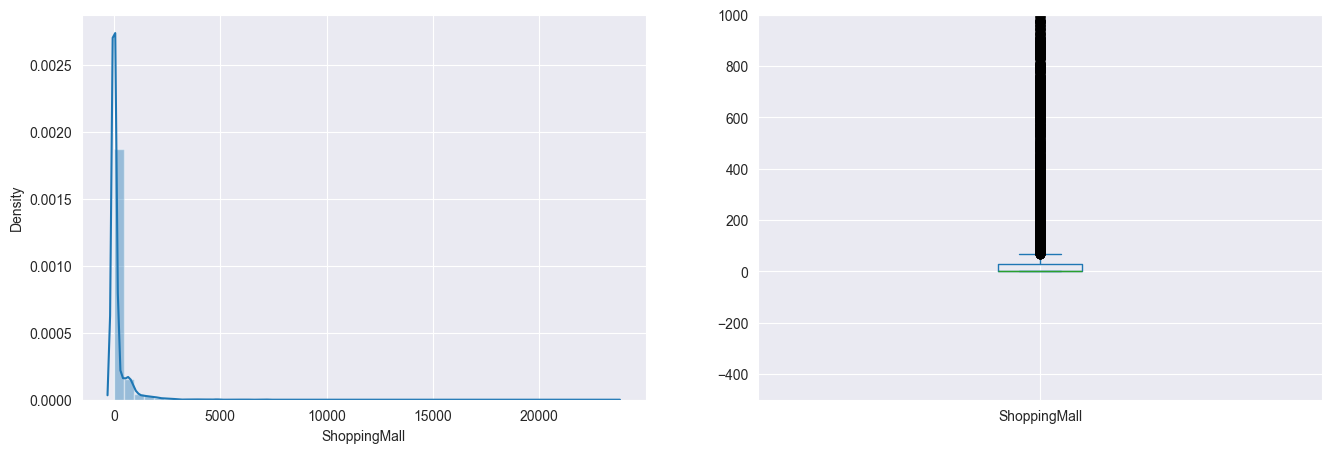

In [ ]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['ShoppingMall']);
plt.subplot(122)
train_df_1['ShoppingMall'].plot.box(figsize = (16, 5));
plt.ylim([-500, 1000])
plt.show()

We can see that rest of the numerical independent variables have a similar distribution. They are not normally distributed, and they all have outliers.

## Bivariate Analysis



### Categorical variables vs target variable.

Number of passengers transported, and the percentage of passengers transported for each categorical variable.

In [ ]:

HomePlanet_Transported = train_df_1.groupby('HomePlanet').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

HomePlanet_Transported['TransportedPercentage'] = HomePlanet_Transported['Transported'] / HomePlanet_Transported['PassengerId']

CryoSleep_Transported = train_df_1.groupby('CryoSleep').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

CryoSleep_Transported['TransportedPercentage'] = CryoSleep_Transported['Transported'] / CryoSleep_Transported['PassengerId']

Destination_Transported = train_df_1.groupby('Destination').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

Destination_Transported['TransportedPercentage'] = Destination_Transported['Transported'] / Destination_Transported['PassengerId']

VIP_Transported = train_df_1.groupby('VIP').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

VIP_Transported['TransportedPercentage'] = VIP_Transported['Transported'] / VIP_Transported['PassengerId']

<Axes: xlabel='VIP', ylabel='TransportedPercentage'>

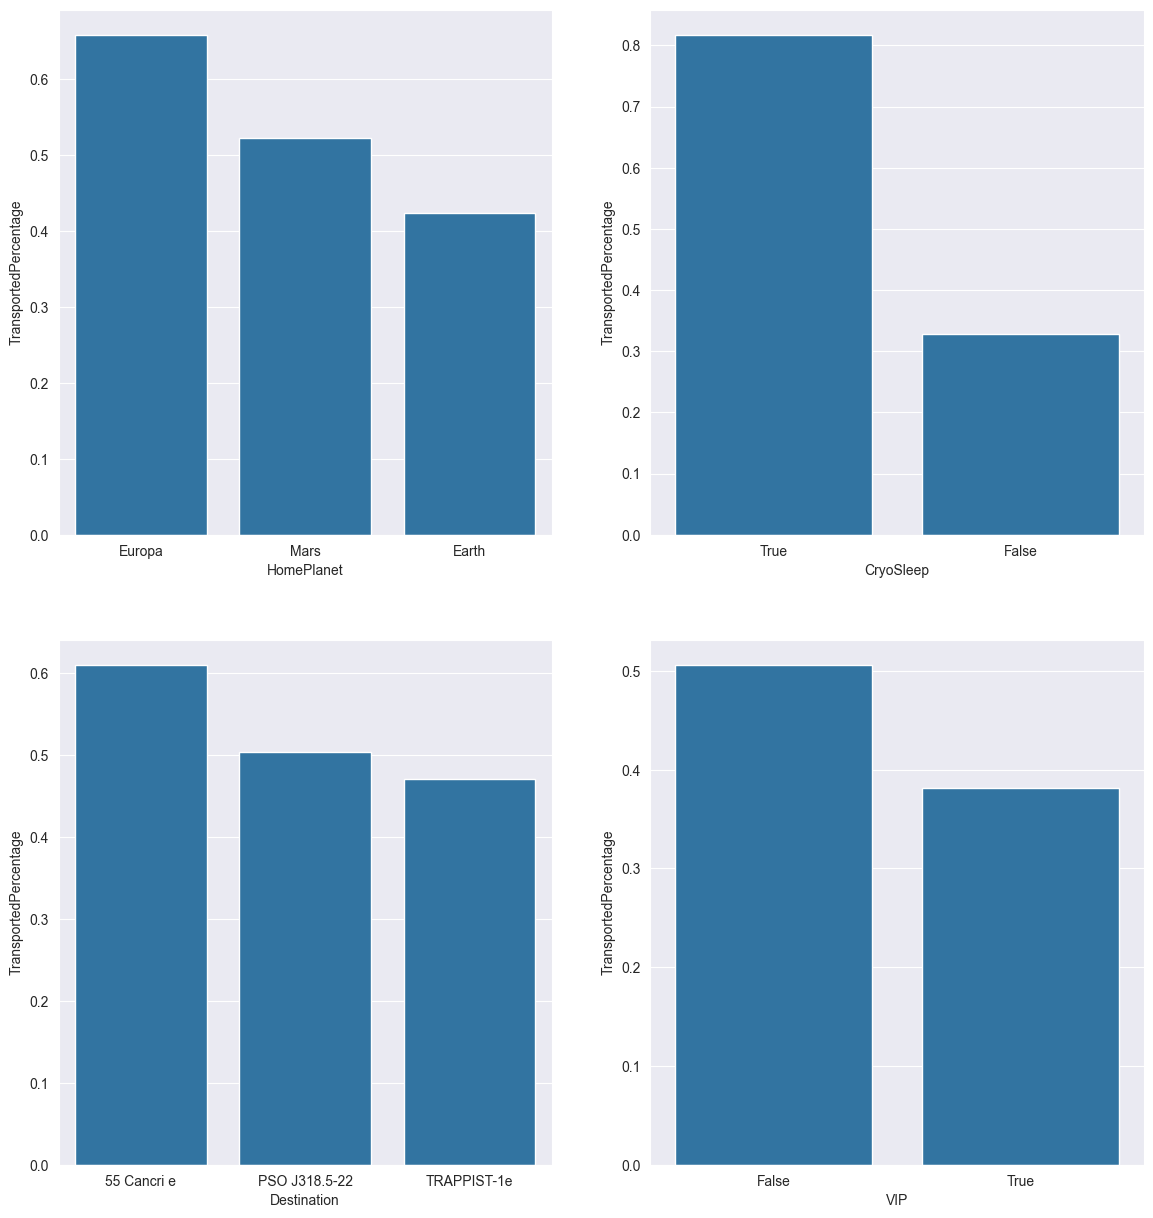

In [ ]:
plt.figure(figsize = (14, 15))
plt.subplot(221)
sns.barplot(x = "HomePlanet", y = "TransportedPercentage", data = HomePlanet_Transported, order = HomePlanet_Transported.sort_values('TransportedPercentage', ascending = False).HomePlanet)
plt.subplot(222)
sns.barplot(x = "CryoSleep", y = "TransportedPercentage", data = CryoSleep_Transported, order = CryoSleep_Transported.sort_values('TransportedPercentage', ascending = False).CryoSleep)
plt.subplot(223)
sns.barplot(x = "Destination", y = "TransportedPercentage", data = Destination_Transported, order = Destination_Transported.sort_values('TransportedPercentage', ascending = False).Destination)
plt.subplot(224)
sns.barplot(x = "VIP", y = "TransportedPercentage", data = VIP_Transported, order = VIP_Transported.sort_values('TransportedPercentage', ascending = False).VIP)

- About 64% of the Passengers from Europa were Transported
- About 78% of the Passengers in CryoSleep were transported
- The proportion of Passengers debarking to 55 Cancri e transported to another dimension is greater compared to those debarking to PSO J318.5–22 and TRAPPIST-1e
- About 38% of the Passengers that paid for special VIP services were transported

Next, let’s look at how the `CabinDeck` and `CabinSide` columns relate to transported. We will follow the same steps as above.

<Axes: xlabel='CabinSide', ylabel='TransportedPercentage'>

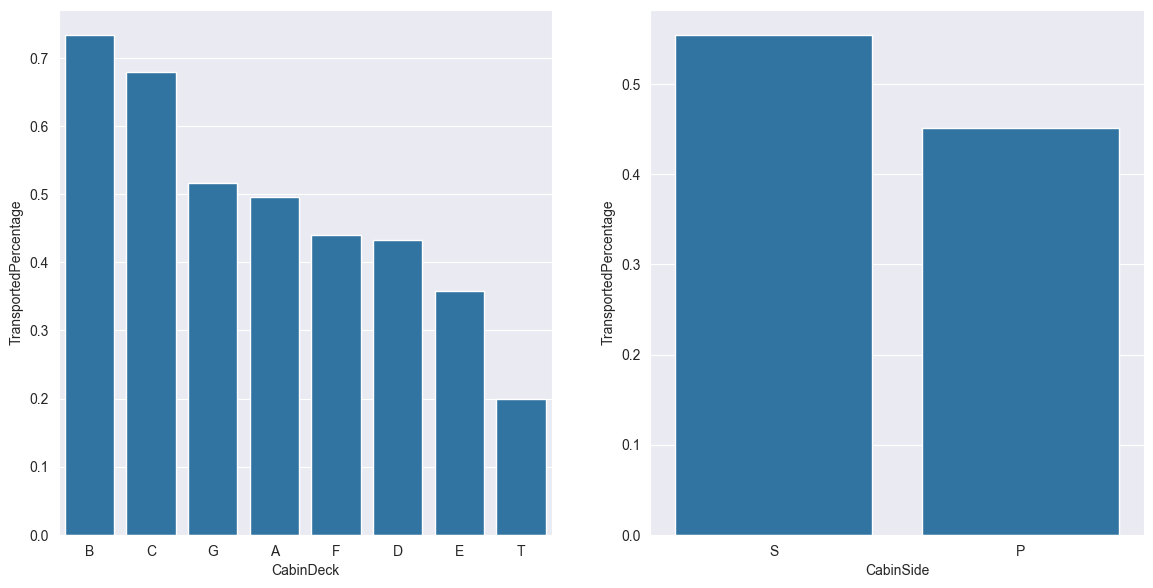

In [ ]:
CabinDeck_Transported = train_df_1.groupby('CabinDeck').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

CabinDeck_Transported['TransportedPercentage'] = CabinDeck_Transported['Transported'] / CabinDeck_Transported['PassengerId']

CabinSide_Transported = train_df_1.groupby('CabinSide').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

CabinSide_Transported['TransportedPercentage'] = CabinSide_Transported['Transported'] / CabinSide_Transported['PassengerId']

# Visualize Cabin features vs target variable
plt.figure(figsize = (14, 15))
plt.subplot(221)
sns.barplot(x = "CabinDeck", y = "TransportedPercentage", data = CabinDeck_Transported, order = CabinDeck_Transported.sort_values('TransportedPercentage', ascending = False).CabinDeck)
plt.subplot(222)
sns.barplot(x = "CabinSide", y = "TransportedPercentage", data = CabinSide_Transported, order = CabinSide_Transported.sort_values('TransportedPercentage', ascending = False).CabinSide)

- Cabin Deck B and C have the highest percentage of passengers transported
- The proportion of Passengers in Cabin Side S transported to another dimension is greater compared to those in Cabin Side P


The `PassengerId` column follows the format `gggg_pp`, where `gggg` represents the group the passenger is traveling with, and `pp` is their number within the group. To understand how the group size affects whether passengers are transported or not, we will extract the `PassengerGroup` feature from the `PassengerId` column, determine the number of people in each group, and then visualize its relationship with the `Transported` feature.


- *Extract `PassengerGroup` column from `PassengerId` column*
- *Create dataframe `No_People_In_PassengerGroup` that contains the `PassengerGroup` and the no passengers in the group*
- *Create dataframe `NoInPassengerGroup_Transported` that has number of passengers in a group transported and the percentage of passengers in a group transported*

<Axes: xlabel='NoInPassengerGroup', ylabel='TransportedPercentage'>

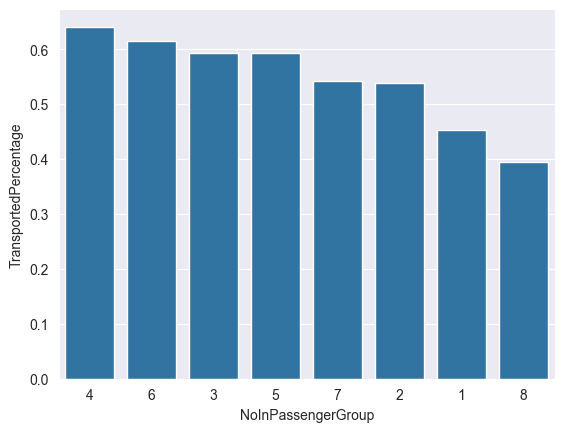

In [ ]:
train_df_1["PassengerGroup"] = train_df_1["PassengerId"].str.split('_', expand = True)[0]


No_People_In_PassengerGroup = train_df_1.groupby('PassengerGroup').aggregate({'PassengerId': 'size'}).reset_index()
No_People_In_PassengerGroup = No_People_In_PassengerGroup.rename(columns = {"PassengerId": "NoInPassengerGroup"})

train_df_1 = train_df_1.merge(No_People_In_PassengerGroup[["PassengerGroup", "NoInPassengerGroup"]], how = 'left', on = ['PassengerGroup'])
# create dataframe NoInPassengerGroup_Transported that has No of passengers in a group transported and the percentage of passengers in a group transported
NoInPassengerGroup_Transported = train_df_1.groupby('NoInPassengerGroup').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

NoInPassengerGroup_Transported['TransportedPercentage'] = NoInPassengerGroup_Transported['Transported'] / NoInPassengerGroup_Transported['PassengerId']

# Visualize NoInPassengerGroup vs transported
sns.barplot(x = "NoInPassengerGroup", y = "TransportedPercentage", data = NoInPassengerGroup_Transported, order = NoInPassengerGroup_Transported.sort_values('TransportedPercentage', ascending = False).NoInPassengerGroup)

There is no clear pattern indicating how the number of people in a group affects whether they are transported or not. Therefore, we will examine how being alone or not influences the likelihood of a passenger being transported.


- *Create a new column `IsAlone` to indicate if a passenger is alone or not*
- *Merge the `IsAlone` information back into the main dataframe based on `PassengerGroup`*
- *Group by `IsAlone` and calculate the total number of transported passengers and total passengers*
- *Create a new column `TransportedPercentage` for the percentage of passengers transported who are alone or not alone*

<Axes: xlabel='IsAlone', ylabel='TransportedPercentage'>

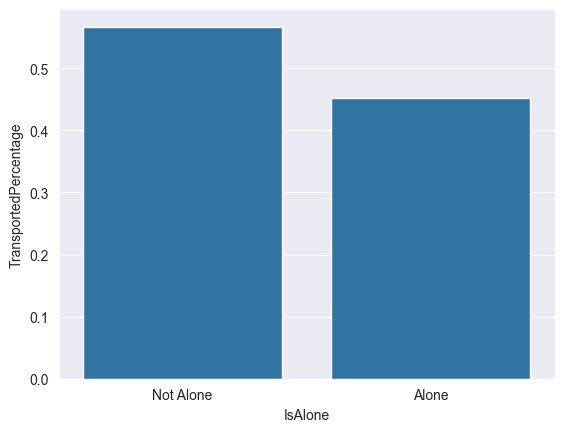

In [ ]:
No_People_In_PassengerGroup["IsAlone"] = No_People_In_PassengerGroup["NoInPassengerGroup"].apply(lambda x: "Not Alone" if x > 1 else "Alone")
train_df_1 = train_df_1.merge(No_People_In_PassengerGroup[["PassengerGroup", "IsAlone"]], how = 'left', on = ['PassengerGroup'])

IsAlone_Transported = train_df_1.groupby('IsAlone').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

IsAlone_Transported['TransportedPercentage'] = IsAlone_Transported['Transported'] / IsAlone_Transported['PassengerId']

sns.barplot(x = "IsAlone", y = "TransportedPercentage", data = IsAlone_Transported, order = IsAlone_Transported.sort_values('TransportedPercentage', ascending = False).IsAlone)

It appears that passengers who were not alone were more likely to be transported to another dimension compared to those who were alone.

We will test the H0 ("Passengers who were not alone are equally likely to be transported as those who were alone.") using a two-proportion z-test to compare the proportions.


- *Extract `FamilyName` from `Name` column*
- *Create dataframe `NoRelatives` that contains the `FamilyName` and the `NoRelatives`*
- *Create dataframe `FamilySizeCat_Transported` that has the Family Size Category and the percentage transported*

<Axes: xlabel='FamilySizeCat', ylabel='TransportedPercentage'>

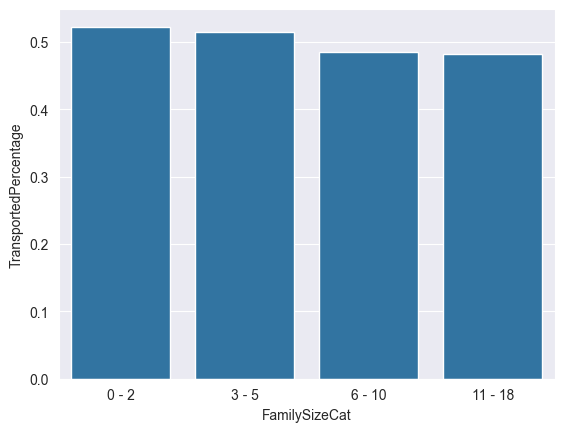

In [ ]:
train_df_1["FamilyName"] = train_df_1["Name"].str.split(' ', expand = True)[1]

NoRelatives = train_df_1.groupby('FamilyName')['PassengerId'].count().reset_index()
NoRelatives = NoRelatives.rename(columns = {"PassengerId": "NoRelatives"})

train_df_1 = train_df_1.merge(NoRelatives[["FamilyName", "NoRelatives"]], how = 'left', on = ['FamilyName'])

train_df_1["FamilySizeCat"] = pd.cut(train_df_1.NoRelatives, bins = [0, 2, 5, 10, 18], labels = ['0 - 2', '3 - 5', '6 - 10', '11 - 18'])

FamilySizeCat_Transported = train_df_1.groupby('FamilySizeCat').aggregate({'Transported': 'sum',
                                                           'PassengerId': 'size'
                                                          }).reset_index()

FamilySizeCat_Transported['TransportedPercentage'] = FamilySizeCat_Transported['Transported'] / FamilySizeCat_Transported['PassengerId']

sns.barplot(x = "FamilySizeCat", y = "TransportedPercentage", data = FamilySizeCat_Transported, order = FamilySizeCat_Transported.sort_values('TransportedPercentage', ascending = False).FamilySizeCat)

A higher percentage of smaller families were transported compared to larger families. This might be because smaller families are wealthier and thus more likely to be transported.

To explore how family size affects income, we will sum the amounts each passenger spent at the various luxury amenities on the Spaceship Titanic, create new column `TotalSpendings` and plot this against the `FamilySizeCat` feature.

- *Create `TotalSpendings` feature*

(-800.0, 12000.0)

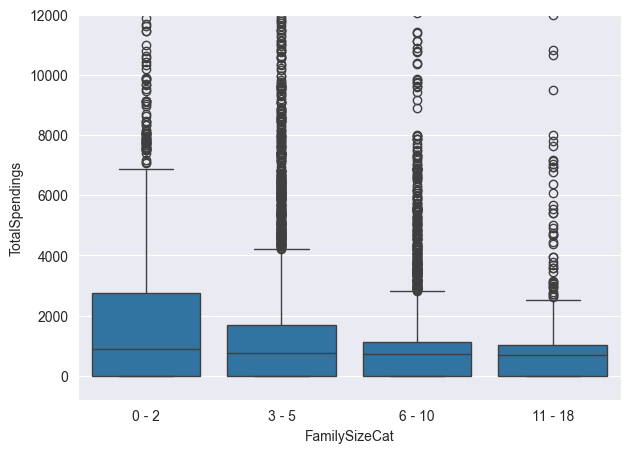

In [ ]:
train_df_1["TotalSpendings"] = train_df_1["FoodCourt"] + \
                                 train_df_1["ShoppingMall"] + \
                                 train_df_1["RoomService"] + \
                                 train_df_1["Spa"] + \
                                 train_df_1["VRDeck"]

plt.figure(figsize = (7, 5))
sns.boxplot(data = train_df_1, x = "FamilySizeCat", y = "TotalSpendings")
plt.ylim([-800, 12000])

Our hypothesis appears to be correct: passengers with smaller family sizes tend to be wealthier.

### Numerical independent variables vs target variable

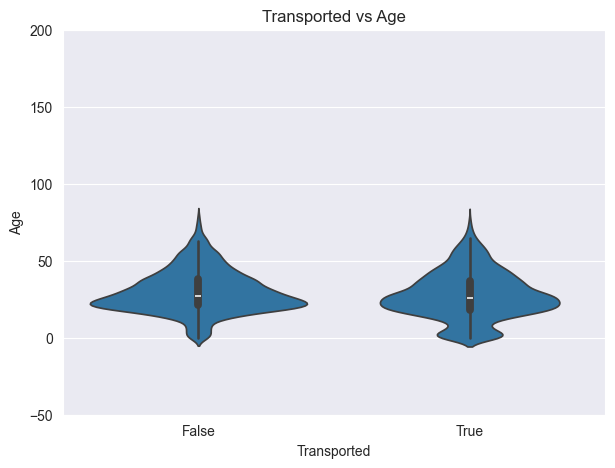

In [ ]:
plt.figure(figsize=(7, 5))
sns.violinplot(x="Transported", y="Age", data=train_df_1)
plt.ylim([-50, 200])
plt.title('Transported vs Age')
plt.show()

Based on the violin plot, it appears that there is a noticeable width in the distribution for passengers aged 0 to about 4 who were transported (orange plot).

We will create a new column `AgeCat` to confirm if more younger passengers were transported compared to older passengers.

- *Extract `AgeCat` from `Age` column*
- *Group by `AgeCat` and calculate the number of transported passengers and total passengers*
- *Create a new column for the percentage of transported passengers*

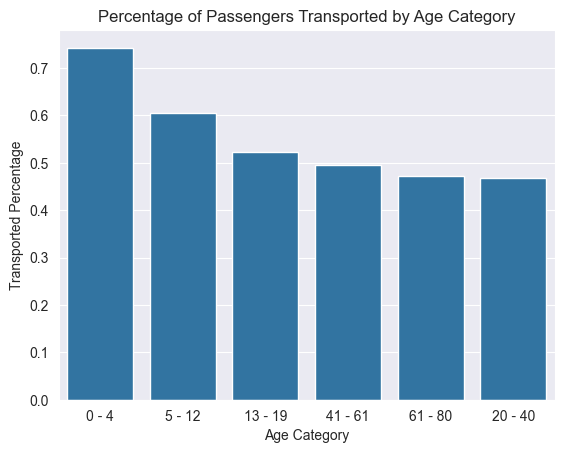

In [ ]:
train_df_1["AgeCat"] = pd.cut(train_df_1.Age, bins=[0.0, 4.0, 12.0, 19.0, 40.0, 60.0, 80.0], labels=['0 - 4', '5 - 12', '13 - 19', '20 - 40', '41 - 61', '61 - 80'])

AgeCat_Transported = train_df_1.groupby('AgeCat').aggregate({'Transported': 'sum', 'PassengerId': 'size'}).reset_index()

AgeCat_Transported['TransportedPercentage'] = AgeCat_Transported['Transported'] / AgeCat_Transported['PassengerId']

sns.barplot(x="AgeCat", y="TransportedPercentage", data=AgeCat_Transported, order=AgeCat_Transported.sort_values('TransportedPercentage', ascending=False)['AgeCat'])
plt.title('Percentage of Passengers Transported by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Transported Percentage')
plt.show()

- About 74% of passengers within the Age range of 0–4 were transported
- About 60% of passengers within the Age range of 5–12 were transported

Now, we'll do the same for the remaining numerical independent variables.

(-800.0, 2000.0)

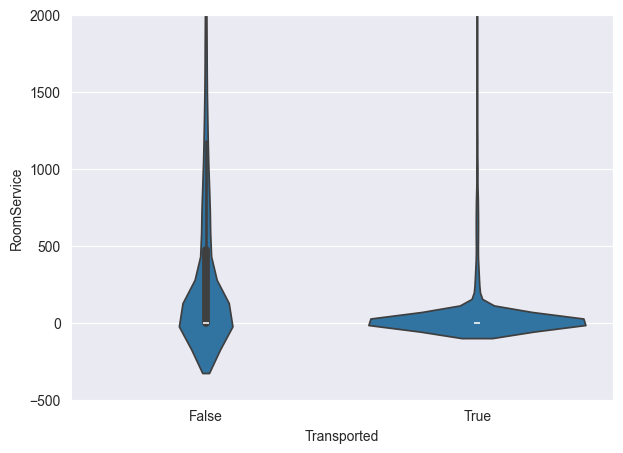

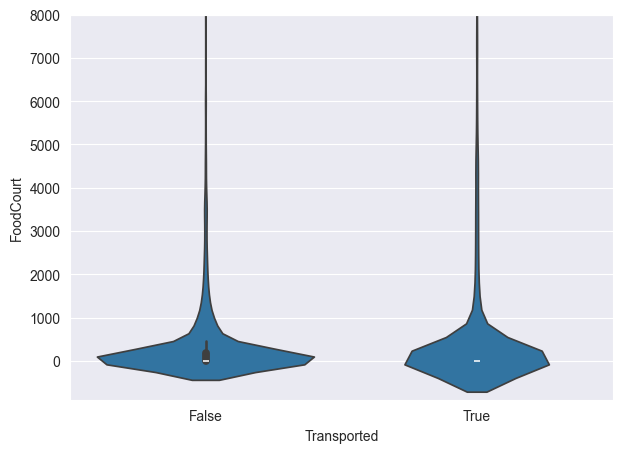

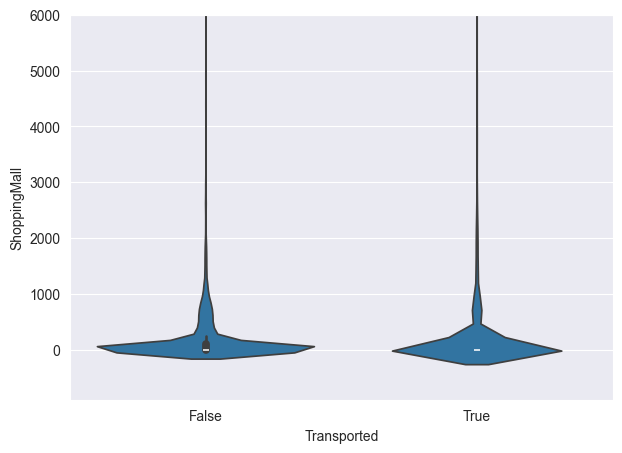

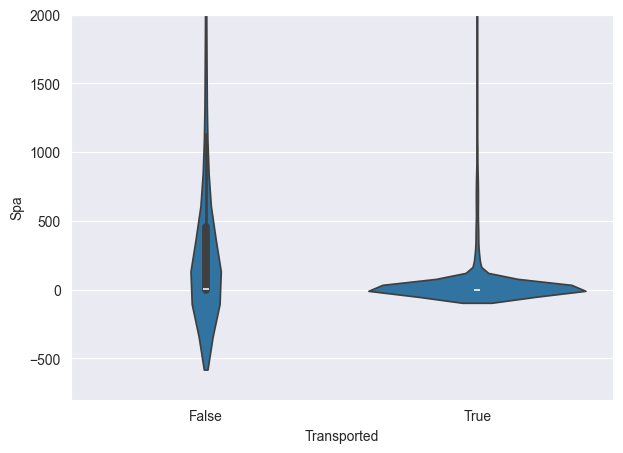

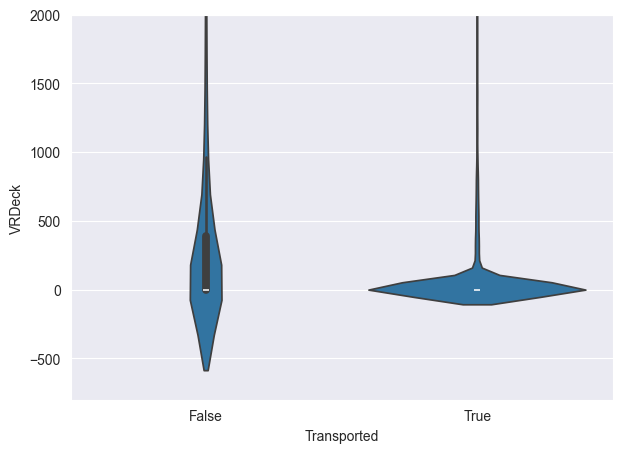

In [ ]:
plt.figure(figsize = (7, 5))
sns.violinplot(x="Transported", y="RoomService", data=train_df_1)
plt.ylim([-500, 2000])

plt.figure(figsize = (7, 5))
sns.violinplot(x="Transported", y="FoodCourt", data=train_df_1)
plt.ylim([-900, 8000])

plt.figure(figsize = (7, 5))
sns.violinplot(x="Transported", y="ShoppingMall", data=train_df_1)
plt.ylim([-900, 6000])

plt.figure(figsize = (7, 5))
sns.violinplot(x="Transported", y="Spa", data=train_df_1)
plt.ylim([-800, 2000])

plt.figure(figsize = (7, 5))
sns.violinplot(x="Transported", y="VRDeck", data=train_df_1)
plt.ylim([-800, 2000])

- The bills spent by transported passengers appear to be concentrated and approaching zero.
- VRDeck, Spa, and RoomService have similar distributions.
- ShoppingMall and RoomService also share a similar distribution pattern.


We’ve explored the impact of family size on expenditure. Now, let’s examine how being in Cryosleep affects passenger spending.

(-900.0, 14000.0)

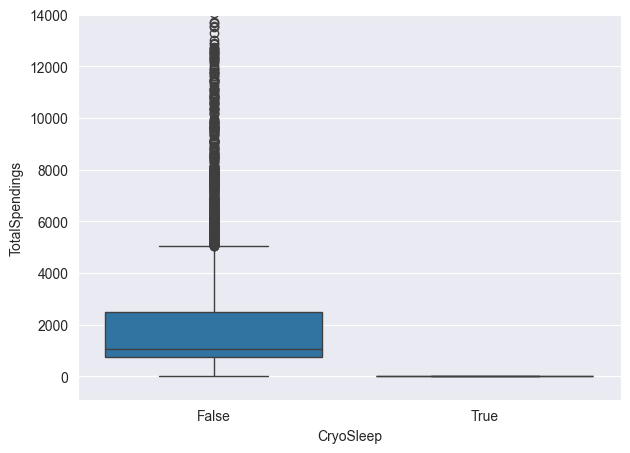

In [ ]:
plt.figure(figsize = (7, 5))

sns.boxplot(data = train_df_1, x = "CryoSleep", y = "TotalSpendings")
plt.ylim([-900, 14000])

- Passengers in CryoSleep have 0 expenditure.

Now let’s see how VIP status affects expenditure.

(-800.0, 12000.0)

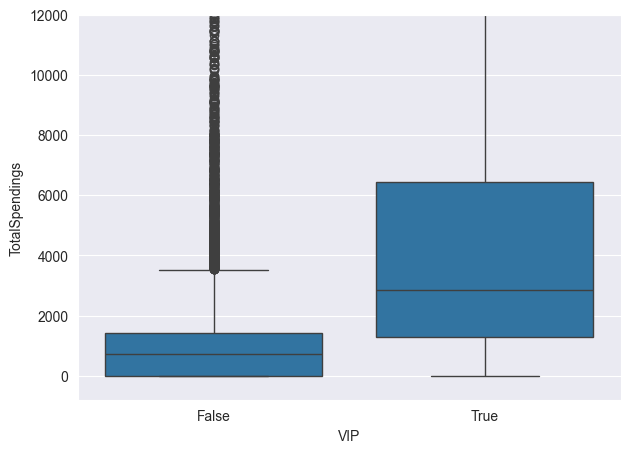

In [ ]:
plt.figure(figsize = (7, 5))

sns.boxplot(data = train_df_1, x = "VIP", y = "TotalSpendings")
plt.ylim([-800, 12000])

- Passengers with VIP status have a higher expenditure compared to passengers who don’t.

Let’s see how the age category relates to total spending of a passenger.

(-800.0, 12000.0)

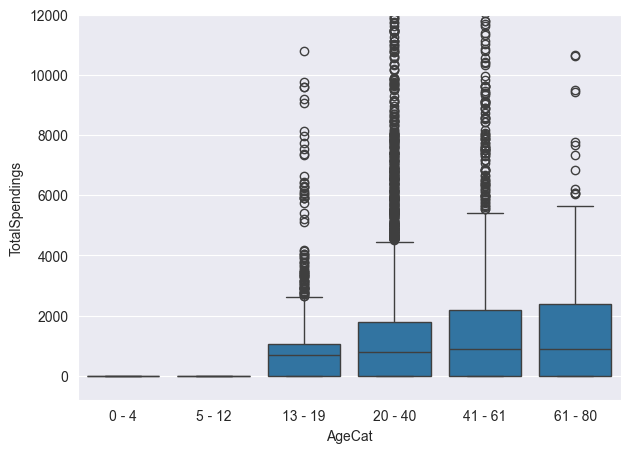

In [ ]:
plt.figure(figsize = (7, 5))
sns.boxplot(data = train_df_1, x = "AgeCat", y = "TotalSpendings")
plt.ylim([-800, 12000])

- Passengers within the age range of 0–12 had 0 expenditure
- Expenditure increases with the Age

## Inferential stats

Cleaning the copy of train data `data_infst` (categorical with mode, numerical with mean, outliers cut above 99th percentile).

In [ ]:
data_infst=train_df.copy()
list_missing_cat_columns = list((data_infst.select_dtypes(['object', 'category']).isna().sum() > 0).index)

for col in list_missing_cat_columns:
    data_infst[col] = data_infst[col].fillna(data_infst[col].mode()[0])

data_infst = utils.fill_nans_by_age_and_cryosleep(data_infst)

data_infst = utils.clipping_quantile(data_infst, None, 0.99)
data_corr=data_infst.copy()


In [ ]:
data_infst.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'FamilyName', 'NoRelatives', 'IsAlone'],
      dtype='object')

### H(0): Passengers who are not alone are not more likely to be transported than those who are alone. (i.e., the proportion of transported passengers is the same or lower for those not alone compared to those alone).

- Calculate Proportions:
    - Calculate the proportion of passengers transported for both groups: Alone and Not Alone.
- Perform a Proportion Z-Test:
    - Use the statsmodels library to perform a one-tailed z-test to compare the proportions.

In [ ]:
contingency_table = pd.crosstab(data_infst['IsAlone'], data_infst['Transported'])

print(contingency_table)

count = contingency_table[True].values
nobs = contingency_table.sum(axis=1).values

stat, p_value = proportions_ztest(count, nobs, alternative='larger')

print(f"Proportion Z-Test p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. Passengers who are not alone are more likely to be transported than those who are alone.")
else:
    print("We fail to reject the null hypothesis. There is no significant evidence that passengers who are not alone are more likely to be transported than those who are alone.")


Transported  False  True 
IsAlone                  
Alone          159    223
Not Alone     4156   4155
Proportion Z-Test p-value: 0.0006773016390730338
We reject the null hypothesis. Passengers who are not alone are more likely to be transported than those who are alone.


Transported Percentages:
   - **Not Alone**: Approximately 49.99% of passengers who were not alone were transported.
   - **Alone**: Approximately 58.38% of passengers who were alone were transported.

Confidence Intervals:
   - **Not Alone**: The true transported percentage for passengers who were not alone is likely between 48.92% and 51.07%.
   - **Alone**: The true transported percentage for passengers who were alone is likely between 53.43% and 63.32%.

Z-Statistic and P-Value:
   - **Z-Statistic**: -3.204
   - **P-Value**: 0.00135

Since the p-value (0.00135) is less than the significance level (alpha = 0.05), we reject the null hypothesis.

Therefore, passengers who were alone were more likely to be transported compared to those who were not alone.

## Correlations between numerical features and the target variable `Transported`

Label Encoding:
   - We'll use `LabelEncoder` to convert each categorical variable into an integer code, which is faster and less memory-intensive than one-hot encoding.
   - Each unique category within a column is assigned an integer, which allows us to calculate the correlation matrix directly.
  
Correlation Matrix:
   - We'll calculate the correlation matrix across the encoded categorical variables, numerical variables, and `Transported`.
  
Heatmap:
   - The heatmap visualization shows correlations between all variables, including how categorical variables (now integers) relate to `Transported`.


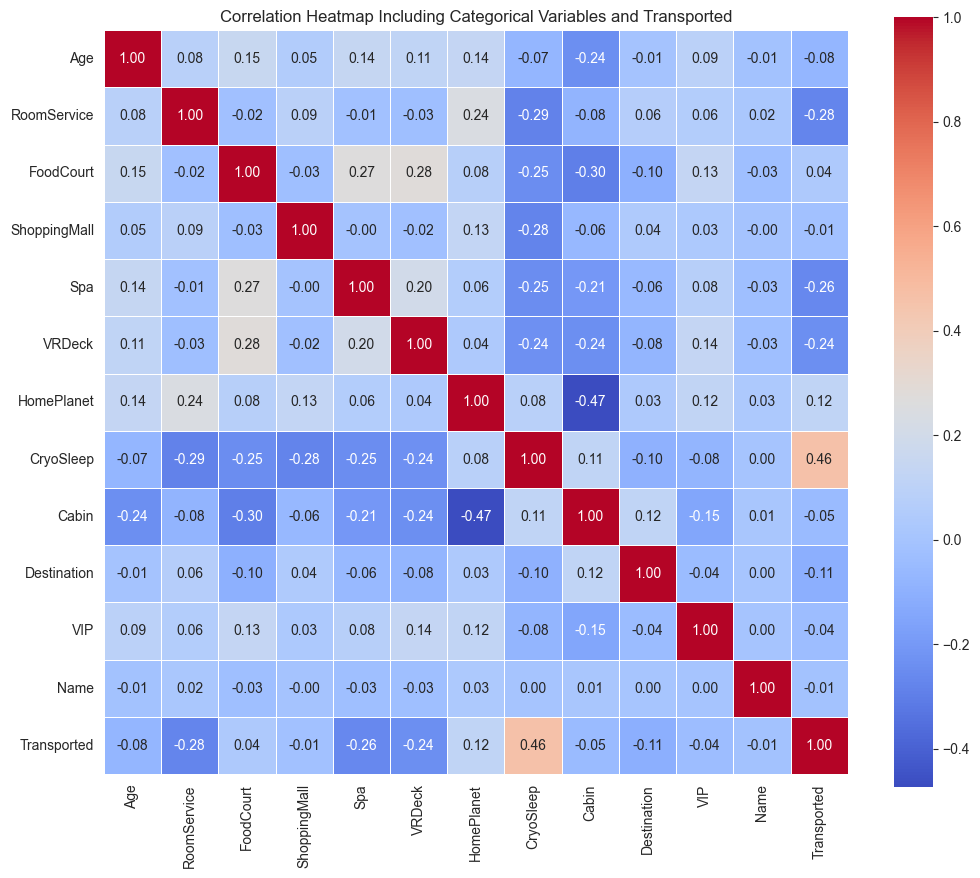

In [ ]:
label_encoder = LabelEncoder()

for col in ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']:
    data_corr[col] = label_encoder.fit_transform(data_corr[col].astype(str))

data_corr['Transported'] = data_corr['Transported'].astype(int)

columns_of_interest = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                       'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'Transported']

corr_matrix = data_corr[columns_of_interest].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Heatmap Including Categorical Variables and Transported')
plt.show()

`CryoSleep` and `Transported`:
   - There is a **strong positive correlation** of `0.46` between `CryoSleep` and `Transported`. This suggests that passengers who were in CryoSleep were more likely to be transported (or vice versa).

`RoomService` and `Transported`:
   - There is a **negative correlation** of `-0.28` between `RoomService` and `Transported`. This implies that passengers who spent more on room service were less likely to be transported.

`Spa` and `Transported`:
   - The `Spa` variable also has a **negative correlation** of `-0.26` with `Transported`, suggesting that higher spending on the spa might be associated with a lower likelihood of being transported.

`VRDeck` and `Transported`:
   - The `VRDeck` variable shows a **negative correlation** of `-0.24` with `Transported`. This implies that passengers who spent more on VRDeck facilities were less likely to be transported.

Relationships Among Variables:
`HomePlanet` and `Cabin`:
   - There is a **negative correlation** of `-0.47` between `HomePlanet` and `Cabin`, which may indicate some distinct distribution of passengers' home planets across different cabins.

Cabin` and other Numerical Variables**:
   - The `Cabin` variable shows negative correlations with `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck`. This could imply that cabin assignments might be associated with the passengers' spending habits or preferences.

`FoodCourt` and `VRDeck`:
   - There is a positive correlation between `FoodCourt` and `VRDeck` (`0.28`). Passengers who spent more on VRDeck also tended to spend more at the FoodCourt.

`Age` and Other Variables:
   - `Age` has a low or negligible correlation with most variables, except for a slight positive correlation with `Spa` (`0.14`).

###

# Cleaning and Preprocessing

In [ ]:
train_df_2 = train_df_1.copy()

train_df_2 = train_df_2.drop(["PassengerGroup",
                              "CabinDeck",
                              "CabinNo.",
                              "CabinSide",
                              "FamilyName",
                              "NoRelatives",
                              "NoInPassengerGroup",
                              "IsAlone",
                              "AgeCat",
                              "FamilySizeCat",
                              "TotalSpendings"], axis = 1)

We will merge the train and test datasets to streamline the cleaning and preprocessing steps.

- *Save target variable in train dataset and save it in `target`*
- *Save test PassengerId in `test_id`*
- *Drop `Transported` variable from the train set*
- *Join the train and test set in `data`*

In [ ]:
target = train_df_2["Transported"]

test_id = test_df_1["PassengerId"]

train_df_3 = train_df_2.drop(["Transported"], axis = 1)

data = pd.concat([train_df_3, test_df], axis = 0).reset_index(drop = True)

Let’s examine the shape of our newly combined dataset.

In [ ]:
data.shape

(12970, 13)

`data` contains 12,970 rows and 13 columns. Let’s examine the percentage of missing values for each variable.

In [ ]:
round(data.isna().sum() * 100/data.shape[0], 3)

PassengerId    0.00
HomePlanet     2.22
CryoSleep      2.39
Cabin          2.31
Destination    2.11
Age            2.08
VIP            2.28
RoomService    2.03
FoodCourt      2.23
ShoppingMall   2.36
Spa            2.19
VRDeck         2.07
Name           2.27
dtype: float64

Every column, except for `PassengerId`, contains missing values. However, the missing values do not exceed 50% of any variable.

## Handling of the missing values in the **categorical** features

Using impution with the mode. This approach helps maintain the integrity of the data distribution.

- *Create a copy of `data`*
- *Identify the categorical columns in the `data_1` that contain missing values and save them in `missing_cat_cols`*

In [ ]:
data_1 = data.copy()

list_missing_cat_columns = list((data_1.select_dtypes(['object', 'category']).isna().sum() > 0).index)
list_missing_cat_columns

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

- *Impute missing values in categorical columns with the mode*

In [ ]:
for col in list_missing_cat_columns:
    data_1[col] = data_1[col].fillna(data_1[col].mode()[0])

## Handling the missing values in the **numerical** features.

- *Identify the numeric columns with missing values and save them in `list_missing_numeric_col`*

In [ ]:
list_missing_numeric_col = list((data_1.select_dtypes(np.number).isna().sum() > 0).index)
list_missing_numeric_col

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

Regarding `Age`, we observed (through EDA) that the totals for `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` are 0 when the passenger’s age is less than 13 or if they are in cryosleep.

- *`fill_nans_by_age_and_cryosleep` ensures that for passengers who are either under 13 years old or in cryosleep, the values for “RoomService,” “FoodCourt,” “ShoppingMall,” “Spa,” and “VRDeck” are set to 0.*

In [ ]:
data_1 = utils.fill_nans_by_age_and_cryosleep(data_1)

- *Fill rest of the numeric columns in `data_1` with mean*

In [ ]:
for col in list_missing_numeric_col:
    data_1[col] = data_1[col].fillna(data_1[col].mean())
data_1.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

All the missing values have been filled in the dataset `data_1`.

## Outliers

During our univariate analysis, we identified outliers in the `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck` columns.

To address this, we need to treat these outliers as they can distort the data distribution. We will clip the outliers at the 99th percentile.

In [ ]:
data_1 = utils.clipping_quantile(data_1, None, 0.99)

The `data_1` dataset is clean of missing values and outliers.

# Feature Engineering

Based on our EDA, we'll develop a function to generate new features that could influence the target variable.

In [ ]:
data_2 = data_1.copy()
data_2 = utils.extract_features(data_2)

Next, we'll drop the variables we used to create these new features, as they may no longer be relevant and could introduce noise into the dataset.

In [ ]:
data_3 = data_2.copy()
irrelevant_columns = ["Cabin", "PassengerId", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Name", "FamilyName", "PassengerGroup"]
data_3 = data_3.drop(irrelevant_columns, axis = 1)

data_3.shape

(12970, 16)

Next, we’ll transform our categorical data into numerical data that the model can understand.

In [ ]:
data_3 = pd.get_dummies(data_3, columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinSide', 'IsAlone'])

for col in ['CabinDeck', 'DeckPosition', 'FamilySizeCat']:
    data_3[col], _ = data_3[col].factorize()

Then we'll split the data back to get the train and test data.

In [ ]:
data_4 = data_3.copy()
train_data_final = data_4.loc[:train_df.index.max(),  :].copy()
test_data_final = data_4.loc[train_df.index.max() + 1:, :].reset_index(drop = True).copy()

Ensure that the shape of the train and test data is right.

In [ ]:
print(f"Train shape: {train_data_final.shape}, Test shape: {test_data_final.shape}")

Train shape: (8693, 24), Test shape: (4277, 24)


In [ ]:
test_data_final.columns

Index(['Age', 'NoInPassengerGroup', 'CabinDeck', 'DeckPosition', 'Regular',
       'Luxury', 'TotalSpendings', 'DeckAverageSpent', 'NoRelatives',
       'FamilySizeCat', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'CryoSleep_False', 'CryoSleep_True',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True', 'CabinSide_P',
       'CabinSide_S', 'IsAlone_Alone', 'IsAlone_Not Alone'],
      dtype='object')

# Modeling

## Fit and evaluate models using `LazyClassifier` from `lazypredict`

In [ ]:
X = train_data_final.copy()
y = target.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [00:00<00:09,  2.98it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7837837837837838, 'Balanced Accuracy': 0.7831671865368182, 'ROC AUC': 0.7831671865368183, 'F1 Score': 0.7828469162125083, 'Time taken': 0.3354067802429199}


 14%|█▍        | 4/29 [00:00<00:04,  6.12it/s]

{'Model': 'BaggingClassifier', 'Accuracy': 0.7573317998849913, 'Balanced Accuracy': 0.7576234393974268, 'ROC AUC': 0.7576234393974268, 'F1 Score': 0.7571564583416011, 'Time taken': 0.3210642337799072}
{'Model': 'BernoulliNB', 'Accuracy': 0.7487061529614721, 'Balanced Accuracy': 0.7494635945383209, 'ROC AUC': 0.7494635945383209, 'F1 Score': 0.747290032842625, 'Time taken': 0.01934504508972168}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7849338700402531, 'Balanced Accuracy': 0.7846209710063258, 'ROC AUC': 0.7846209710063258, 'F1 Score': 0.7846783002260223, 'Time taken': 0.10742592811584473}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7193789534215066, 'Balanced Accuracy': 0.7192396932104694, 'ROC AUC': 0.7192396932104693, 'F1 Score': 0.7193102545753995, 'Time taken': 0.052783966064453125}
{'Model': 'DummyClassifier', 'Accuracy': 0.5048878665899943, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.33877840799848297, 'Time taken': 0.01495218276977539}
{'Model': 'ExtraTr

 31%|███       | 9/29 [00:01<00:03,  6.08it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.7745830937320299, 'Balanced Accuracy': 0.7748089179557595, 'ROC AUC': 0.7748089179557595, 'F1 Score': 0.7744945192816621, 'Time taken': 0.7253768444061279}
{'Model': 'GaussianNB', 'Accuracy': 0.7487061529614721, 'Balanced Accuracy': 0.7490588101455371, 'ROC AUC': 0.7490588101455372, 'F1 Score': 0.7484275493948505, 'Time taken': 0.01771235466003418}


 38%|███▊      | 11/29 [00:01<00:02,  6.36it/s]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.7665324899367453, 'Balanced Accuracy': 0.7666113725894825, 'ROC AUC': 0.7666113725894825, 'F1 Score': 0.7665311003043296, 'Time taken': 0.26004815101623535}


 41%|████▏     | 12/29 [00:04<00:10,  1.69it/s]

{'Model': 'LabelPropagation', 'Accuracy': 0.7395054629097182, 'Balanced Accuracy': 0.7393512602551994, 'ROC AUC': 0.7393512602551994, 'F1 Score': 0.7394261731465955, 'Time taken': 2.7301650047302246}


 45%|████▍     | 13/29 [00:07<00:17,  1.12s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.7435307648073606, 'Balanced Accuracy': 0.7433938128837845, 'ROC AUC': 0.7433938128837846, 'F1 Score': 0.743467978566861, 'Time taken': 3.3176767826080322}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.7602070155261644, 'Balanced Accuracy': 0.7605382838729136, 'ROC AUC': 0.7605382838729137, 'F1 Score': 0.7599770622107315, 'Time taken': 0.056069374084472656}


 52%|█████▏    | 15/29 [00:08<00:11,  1.26it/s]

{'Model': 'LinearSVC', 'Accuracy': 0.7843588269120184, 'Balanced Accuracy': 0.7840514949243211, 'ROC AUC': 0.7840514949243212, 'F1 Score': 0.7841111553335173, 'Time taken': 0.3675999641418457}
{'Model': 'LogisticRegression', 'Accuracy': 0.7826336975273146, 'Balanced Accuracy': 0.7822081385473796, 'ROC AUC': 0.7822081385473795, 'F1 Score': 0.7821718968290038, 'Time taken': 0.030831098556518555}
{'Model': 'NearestCentroid', 'Accuracy': 0.7469810235767682, 'Balanced Accuracy': 0.7476989462377539, 'ROC AUC': 0.7476989462377539, 'F1 Score': 0.7457053806910278, 'Time taken': 0.015625476837158203}


 62%|██████▏   | 18/29 [00:10<00:07,  1.38it/s]

{'Model': 'NuSVC', 'Accuracy': 0.78205865439908, 'Balanced Accuracy': 0.7819647387817842, 'ROC AUC': 0.7819647387817842, 'F1 Score': 0.7820305396417452, 'Time taken': 1.829132080078125}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.7435307648073606, 'Balanced Accuracy': 0.7438997933747642, 'ROC AUC': 0.7438997933747642, 'F1 Score': 0.7432158351137161, 'Time taken': 0.028528451919555664}
{'Model': 'Perceptron', 'Accuracy': 0.7349051178838413, 'Balanced Accuracy': 0.7338509546826675, 'ROC AUC': 0.7338509546826675, 'F1 Score': 0.7316537508362412, 'Time taken': 0.020871877670288086}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.7084531339850488, 'Balanced Accuracy': 0.7076100788668154, 'ROC AUC': 0.7076100788668154, 'F1 Score': 0.7061687054101969, 'Time taken': 0.02887749671936035}


 86%|████████▌ | 25/29 [00:11<00:01,  2.85it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.7826336975273146, 'Balanced Accuracy': 0.7827928271147339, 'ROC AUC': 0.7827928271147339, 'F1 Score': 0.7825991937529828, 'Time taken': 0.8688499927520752}
{'Model': 'RidgeClassifier', 'Accuracy': 0.7602070155261644, 'Balanced Accuracy': 0.7605382838729136, 'ROC AUC': 0.7605382838729137, 'F1 Score': 0.7599770622107315, 'Time taken': 0.02808690071105957}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.7607820586543991, 'Balanced Accuracy': 0.7611077599549181, 'ROC AUC': 0.7611077599549181, 'F1 Score': 0.7605612125739455, 'Time taken': 0.026211261749267578}
{'Model': 'SGDClassifier', 'Accuracy': 0.7613571017826337, 'Balanced Accuracy': 0.7610588154368365, 'ROC AUC': 0.7610588154368365, 'F1 Score': 0.7611015285400685, 'Time taken': 0.05694890022277832}


 93%|█████████▎| 27/29 [00:12<00:00,  2.32it/s]

{'Model': 'SVC', 'Accuracy': 0.7866589994249569, 'Balanced Accuracy': 0.7864305953505353, 'ROC AUC': 0.7864305953505354, 'F1 Score': 0.78651791157453, 'Time taken': 1.3796045780181885}


100%|██████████| 29/29 [00:13<00:00,  2.22it/s]

{'Model': 'XGBClassifier', 'Accuracy': 0.7843588269120184, 'Balanced Accuracy': 0.7841864230552491, 'ROC AUC': 0.7841864230552491, 'F1 Score': 0.7842740598598266, 'Time taken': 0.2825043201446533}
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
{'Model': 'LGBMClassifier', 'Accuracy': 0.78953421506613, 'Balanced Accuracy': 0.7892329997169154, 'ROC AUC': 0.7892329997169155, 'F1 Score': 0.7893007229122753, 'Time taken': 0.10138201713562012}
                               Accuracy  Balanced Accu

### LGBMClassifier

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters: ", study.best_params)
print("Best score: ", study.best_value)

best_model = LGBMClassifier(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)

accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", accuracy)

### AdaBoostClassifier

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters: ", study.best_params)
print("Best score: ", study.best_value)

best_model = AdaBoostClassifier(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)

accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", accuracy)

### CalibratedClassifierCV

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters: ", study.best_params)
print("Best score: ", study.best_value)

best_base_model = AdaBoostClassifier(n_estimators=study.best_params['n_estimators'],
                                     learning_rate=study.best_params['learning_rate'],
                                     random_state=42)
best_model = CalibratedClassifierCV(base_estimator=best_base_model, method=study.best_params['method'], cv=3)
best_model.fit(X_train, y_train)

accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", accuracy)

### LinearSVC

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters: ", study.best_params)
print("Best score: ", study.best_value)

best_base_model = LinearSVC(C=study.best_params['C'], max_iter=study.best_params['max_iter'], random_state=42)
best_model = CalibratedClassifierCV(base_estimator=best_base_model, method=study.best_params['method'], cv=3)
best_model.fit(X_train, y_train)

accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", accuracy)

### LogisticRegression

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters: ", study.best_params)
print("Best score: ", study.best_value)

best_base_model = LogisticRegression(C=study.best_params['C'], solver=study.best_params['solver'], max_iter=study.best_params['max_iter'], random_state=42)
best_model = CalibratedClassifierCV(base_estimator=best_base_model, method=study.best_params['method'], cv=3)
best_model.fit(X_train, y_train)

accuracy = best_model.score(X_test, y_test)
print("Test accuracy: ", accuracy)

### Ensemble model

In [ ]:
logistic = LogisticRegression(C=6.1850820504037465, solver='liblinear', max_iter=961, random_state=42)
svc = LinearSVC(C=0.00050275973687298, max_iter=7576, random_state=42)
ada = AdaBoostClassifier(n_estimators=251, learning_rate=0.08589041383554853, random_state=42)
calibrated_ada = CalibratedClassifierCV(base_estimator=AdaBoostClassifier(n_estimators=333, learning_rate=0.06800223237279028, random_state=42), method='sigmoid', cv=3)

pipeline_logistic = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=15)),
    ('scale', StandardScaler()),
    ('logistic', logistic)
])

pipeline_svc = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=15)),
    ('scale', StandardScaler()),
    ('svc', svc)
])

pipeline_ada = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=15)),
    ('scale', StandardScaler()),
    ('ada', ada)
])

pipeline_calibrated_ada = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=15)),
    ('scale', StandardScaler()),
    ('calibrated_ada', calibrated_ada)
])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters for final estimator: ", study.best_params)
print("Best score: ", study.best_value)

best_final_estimator = LogisticRegression(C=study.best_params['C'], solver=study.best_params['solver'], max_iter=study.best_params['max_iter'], random_state=42)
stacking_ensemble = StackingClassifier(
    estimators=[
        ('logistic', pipeline_logistic),
        ('svc', pipeline_svc),
        ('ada', pipeline_ada),
        ('calibrated_ada', pipeline_calibrated_ada)
    ],
    final_estimator=best_final_estimator
)

stacking_ensemble.fit(X_train, y_train)

accuracy = stacking_ensemble.score(X_test, y_test)
print("Improved stacking ensemble test accuracy: ", accuracy)

### Comparison of performance

#### Single classifiers

In [ ]:
logistic = LogisticRegression(C=6.1850820504037465, solver='liblinear', max_iter=961, random_state=42)
svc = LinearSVC(C=0.00050275973687298, max_iter=7576, random_state=42)
ada = AdaBoostClassifier(n_estimators=251, learning_rate=0.08589041383554853, random_state=42)
lgbm = LGBMClassifier(n_estimators=400, learning_rate=0.01122589318194925, num_leaves=27, random_state=42)

pipeline_logistic = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=15)),
    ('scale', StandardScaler()),
    ('logistic', logistic)
])

svc = SVC(C=0.00050275973687298, probability=True, random_state=42)
pipeline_svc = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=15)),
    ('scale', StandardScaler()),
    ('svc', svc)
])

pipeline_ada = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=15)),
    ('scale', StandardScaler()),
    ('ada', ada)
])

pipeline_lgbm = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=15)),
    ('scale', StandardScaler()),
    ('lgbm', lgbm)
])

models = {
    'Logistic Regression': pipeline_logistic,
    'Linear SVC': pipeline_svc,
    'AdaBoost': pipeline_ada,
    'LGBM': pipeline_lgbm
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} - Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Logistic Regression - Test Accuracy: 0.7832, F1 Score: 0.7948
Linear SVC - Test Accuracy: 0.5049, F1 Score: 0.6710
AdaBoost - Test Accuracy: 0.7815, F1 Score: 0.7970
[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
LGBM - Test Accuracy: 0.7930, F1 Score: 0.8020


#### Ensemble model

In [ ]:
ensemble_soft = VotingClassifier(estimators=[
    ('logistic', pipeline_logistic),
    ('svc', pipeline_svc),
    ('ada', pipeline_ada),
    ('lgbm', pipeline_lgbm)
], voting='soft')

ensemble_soft.fit(X_train, y_train)

y_pred_ensemble_soft = ensemble_soft.predict(X_test)
accuracy_ensemble_soft = accuracy_score(y_test, y_pred_ensemble_soft)
f1_ensemble_soft = f1_score(y_test, y_pred_ensemble_soft)
print(f"Ensemble (Soft Voting) - Test Accuracy: {accuracy_ensemble_soft:.4f}, F1 Score: {f1_ensemble_soft:.4f}")

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
Ensemble (Soft Voting) - Test Accuracy: 0.7872, F1 Score: 0.7998


#### Stacking ensemble model

In [ ]:
stacking_ensemble = StackingClassifier(
    estimators=[
        ('logistic', pipeline_logistic),
        ('svc', pipeline_svc),
        ('ada', pipeline_ada),
        ('lgbm', pipeline_lgbm)
    ],
    final_estimator=LogisticRegression()
)

stacking_ensemble.fit(X_train, y_train)

y_pred_stacking = stacking_ensemble.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)
print(f"Stacking Ensemble - Test Accuracy: {accuracy_stacking:.4f}, F1 Score: {f1_stacking:.4f}")

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
[LightGBM] [Info] Number of positive: 2800, number of negative: 2763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 5563, number of used features: 15
[LightGBM] [Info] [binary:Bo

#### Receiver Operating Characteristic Area Under the Curve

ROC AUC Score: 0.8857


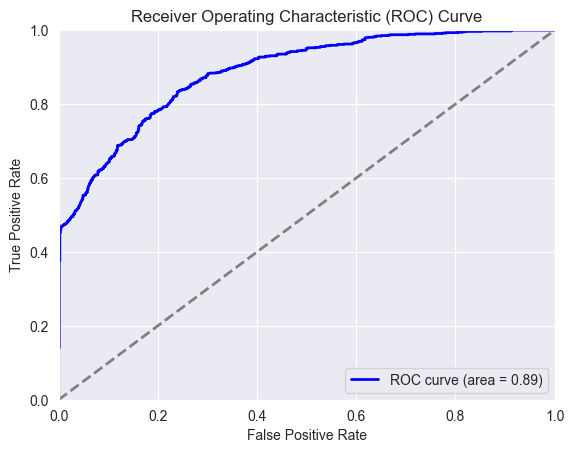

In [ ]:
y_pred_prob_stacking = stacking_ensemble.predict_proba(X_test)[:, 1]

roc_auc_stacking = roc_auc_score(y_test, y_pred_prob_stacking)
print(f'ROC AUC Score: {roc_auc_stacking:.4f}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_stacking)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_stacking:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The ROC AUC score of 0.89 indicates that the model has a high level of accuracy in distinguishing between the positive and negative classes.

High ROC AUC Score: A score of 0.89 suggests the model performs very well.
Curve Shape: The curve is close to the top-left corner, indicating a good balance between sensitivity (true positive rate) and specificity (false positive rate).
Comparison: This curve is significantly above the diagonal line, which represents random guessing.

In [ ]:
predictions = stacking_ensemble.predict(test_data_final)

pred_dict = {"PassengerId": test_df_1["PassengerId"], "Transported": predictions}
pred_df = pd.DataFrame(pred_dict)

pred_df["Transported"] = pred_df["Transported"].map({1: True, 0: False})

pred_df.to_csv("titanic_submission.csv", index=False)

In [ ]:
test_data_final.to_csv("test_data_final.csv", index=False)

In [ ]:
import joblib

joblib.dump(stacking_ensemble, 'stacking_ensemble_model.pkl')

['stacking_ensemble_model.pkl']

# Conclusion

- After comprehensive EDA we were able to determine how we should perform the feature engineering part.
- Regarding modeling it is evident that stacking ensemble model performs best out of the single classifiers (LGBM, AdaBoost, LightSVC, LinearRegression) and VotingClassifier ensemble.
- Final ROC AUC score tells us that our stacking_ensemble model has a high level of accuracy in distinguishing between the positive and negative classes. With a score of 0.89 suggesting the model performs very well.


# Suggestions on improvements

- We could use neural networks such as Multilayer Neural Network which is a baseline neural network that can learn non-linear relationships between inputs and outputs efficiently.